<a href="https://colab.research.google.com/github/NjuChenZhiYu/ML2021-hw-leehy/blob/develop/HW01/HW01-mid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529


Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 176MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 125MB/s]


# **Import Some Packages**

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

You do not need to modify this part.

In [3]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [4]:
torch.cuda.is_available()

True

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取数据文件
file_path = '/content/covid.train.csv'  # 替换为你的实际文件路径
df = pd.read_csv(file_path)

# 2. 初步查看数据结构
print("="*50)
print("数据概览:")
print(f"数据集形状: {df.shape}")  # (行数, 列数)
print(f"前5行数据:")
print(df.head())
print("\n列名列表:")
print(df.columns.tolist())

# 3. 创建列索引映射表
# 为每个列名创建索引映射
# column_index_map = {col: idx for idx, col in enumerate(df.columns)}
# print("\n" + "="*50)
# print("列名索引映射表:")
# for idx, col in enumerate(df.columns):
#     print(f"索引 {idx}: {col}")

# 4. 可视化列分布（可选）
# plt.figure(figsize=(12, 8))
# df.hist(layout=(10, 10), bins=30)  # 10x10的直方图网格
# plt.suptitle('特征分布直方图', fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('feature_distributions.png')
# plt.close()

# 5. 根据要求提取特定列
# 根据题目要求：40个州特征 + 索引57和75的tested_positive特征

# 5.1 确认索引57和75对应的列名
try:
    col_57 = df.columns[58]
    col_75 = df.columns[76]
    print("\n" + "="*50)
    print(f"索引57的列名: {col_57}")
    print(f"索引75的列名: {col_75}")

    # 5.2 提取前40列（州特征）
    state_columns = df.columns[1:41]

    # 5.3 组合所有需要的列
    selected_columns = list(state_columns) + [col_57, col_75]

    # 5.4 创建新的数据子集
    selected_df = df[selected_columns].copy()

    print("\n" + "="*50)
    print("提取后的数据子集信息:")
    print(f"子集形状: {selected_df.shape}")
    print(f"包含的列: {selected_df.columns.tolist()}")
    print("\n子集前5行:")
    print(selected_df.head())

    # 6. 数据质量检查
    print("\n" + "="*50)
    print("数据质量报告:")
    print("缺失值统计:")
    print(selected_df.isnull().sum())

    print("\n数据类型:")
    print(selected_df.dtypes)

    # 7. 保存提取后的数据集（可选）
    selected_df.to_csv('selected_covid_features.csv', index=False)
    print("\n已保存提取后的数据集到 selected_covid_features.csv")

except IndexError as e:
    print("\n错误: 索引超出范围!")
    print(f"数据集只有 {len(df.columns)} 列，但尝试访问索引57或75")
    print("请检查数据并调整索引值")

# 8. 特征相关性分析（针对目标变量）
# 假设目标变量是传播率，列名为'spread_rate'
if 'spread_rate' in df.columns:
    # 计算所有特征与目标的相关性
    correlation_with_target = df.corr()['spread_rate'].sort_values(ascending=False)

    print("\n" + "="*50)
    print("特征与目标变量的相关性排序:")
    print(correlation_with_target)

    # 可视化相关性
    plt.figure(figsize=(10, 8))
    correlation_with_target.drop('spread_rate').plot(kind='bar')
    plt.title('特征与传播率的相关性')
    plt.ylabel('相关系数')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('feature_correlations.png')
    plt.close()
else:
    print("\n未找到目标变量 'spread_rate'，跳过相关性分析")

数据概览:
数据集形状: (2700, 95)
前5行数据:
   id   AL   AK   AZ   AR   CA   CO   CT   FL   GA  ...  restaurant.2  \
0   0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     23.812411   
1   1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     23.682974   
2   2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     23.593983   
3   3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     22.576992   
4   4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     22.091433   

   spent_time.2  large_event.2  public_transit.2  anxious.2  depressed.2  \
0     43.430423      16.151527          1.602635  15.409449    12.088688   
1     43.196313      16.123386          1.641863  15.230063    11.809047   
2     43.362200      16.159971          1.677523  15.717207    12.355918   
3     42.954574      15.544373          1.578030  15.295650    12.218123   
4     43.290957      15.214655          1.641667  14.778802    12.417256   

   felt_isolated.2  worried_become_ill.2  worried_finances.2  \
0        

In [6]:
print(selected_df.columns)
selected_np = selected_df.to_numpy()
print(selected_df.loc[1:5, : ])

Index(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN',
       'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE', 'NV',
       'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX', 'UT',
       'VA', 'WA', 'WV', 'WI', 'tested_positive', 'tested_positive.1'],
      dtype='object')
    AL   AK   AZ   AR   CA   CO   CT   FL   GA   ID  ...   RI   SC   TX   UT  \
1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
5  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    VA   WA   WV   WI  tested_positive  tested_positive.1  
1  0.0  0.0  0.0  0.0        20.151838          20.704935  
2  0.0  0.0  0.0  0.0        20.704935          21.292911  
3  0.0  

In [7]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = list(range(40)) + [57,75]

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]

            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [19]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [43]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        #super(NeuralNet, self).__init__()
        super().__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        return self.criterion(pred, target)

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedNeuralNet(nn.Module):
    ''' 优化的全连接深度神经网络 '''
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.3, l1_lambda=0.001, l2_lambda=0.01):
        super().__init__()

        # 保存正则化参数
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        # 更深的网络架构
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # 批量归一化加速收敛
            nn.LeakyReLU(0.1),           # 缓解梯度消失问题

            nn.Dropout(dropout_rate),     # 防止过拟合

            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.LeakyReLU(0.1),

            nn.Dropout(dropout_rate/2),

            nn.Linear(hidden_dim//2, 1)
        )

        # 初始化权重
        self._initialize_weights()

        # 损失函数 - 考虑使用更鲁棒的损失函数
        self.criterion = nn.HuberLoss(delta=1.0)  # 对异常值不敏感

    def _initialize_weights(self):
        ''' 更智能的权重初始化 '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' 计算损失，包含L1/L2正则化 '''
        base_loss = self.criterion(pred, target)

        # 添加L1和L2正则化
        l1_reg = torch.tensor(0., device=pred.device)
        l2_reg = torch.tensor(0., device=pred.device)

        for param in self.parameters():
            if param.requires_grad:
                l1_reg += torch.norm(param, 1)  # L1正则
                l2_reg += torch.norm(param, 2)  # L2正则

        # 组合损失
        total_loss = base_loss + self.l1_lambda * l1_reg + self.l2_lambda * l2_reg

        return total_loss

In [46]:
import torch
import torch.nn as nn

class TunedNeuralNet(nn.Module):
    ''' 针对COVID传播数据优化的神经网络 '''
    def __init__(self, input_dim, hidden_dim=64, dropout_rate=0.1):
        super().__init__()

        # 更简单但有效的架构
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )

        # 更温和的初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        # 使用原始MSE损失
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' 添加适度的L2正则化 '''
        base_loss = self.criterion(pred, target)

        # 仅添加L2正则化
        l2_reg = torch.tensor(0., device=pred.device)
        for param in self.parameters():
            if param.requires_grad:
                l2_reg += torch.norm(param, 2)

        # 温和的正则化系数
        total_loss = base_loss + 0.001 * l2_reg
        return total_loss

# **Train/Dev/Test**

## **Training**

In [31]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [32]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [23]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [56]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
      'weight_decay': 1e-5           # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [48]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [57]:
model = TunedNeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [58]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 265.3472)
Saving model (epoch =    2, loss = 212.3252)
Saving model (epoch =    3, loss = 156.6894)
Saving model (epoch =    4, loss = 101.2041)
Saving model (epoch =    5, loss = 56.4248)
Saving model (epoch =    6, loss = 34.8282)
Saving model (epoch =    7, loss = 30.3692)
Saving model (epoch =    8, loss = 26.1517)
Saving model (epoch =    9, loss = 22.4342)
Saving model (epoch =   10, loss = 20.3891)
Saving model (epoch =   11, loss = 18.6605)
Saving model (epoch =   12, loss = 17.0889)
Saving model (epoch =   13, loss = 15.8730)
Saving model (epoch =   14, loss = 14.7689)
Saving model (epoch =   15, loss = 13.7613)
Saving model (epoch =   16, loss = 12.7883)
Saving model (epoch =   17, loss = 11.9008)
Saving model (epoch =   18, loss = 11.0791)
Saving model (epoch =   19, loss = 10.2967)
Saving model (epoch =   20, loss = 9.5569)
Saving model (epoch =   21, loss = 8.8420)
Saving model (epoch =   22, loss = 8.1869)
Saving model (epoch =   23, los

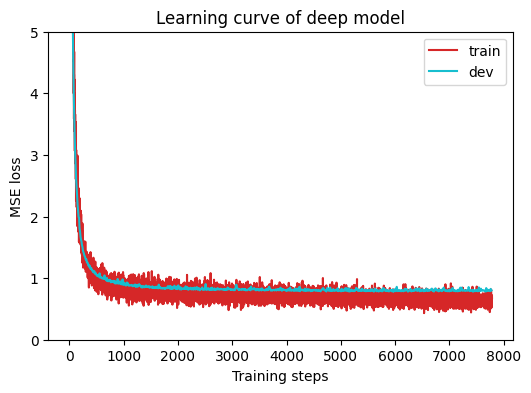

In [37]:
plot_learning_curve(model_loss_record, title='deep model')

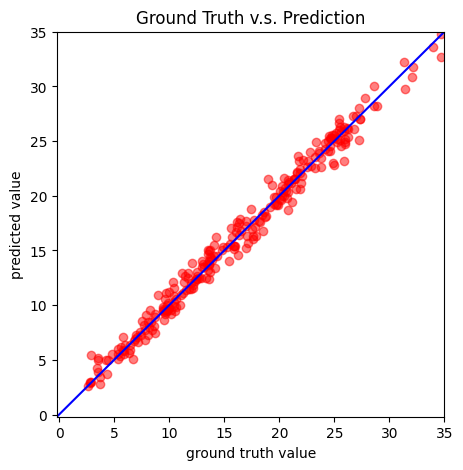

In [38]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [39]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author.

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
